<a href="https://colab.research.google.com/github/mondalanindya/EEEM068_Surrey/blob/main/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1 style="text-align: center">EEEM068 - Applied Machine Learning</H1>
<H1 style="text-align: center">Workshop 05</H1>
<H1 style="text-align: center">GAT Tutorial</H1>

# Graph Attention Networks

Graph Attention Networks (GATs) are one of the most popular types of Graph Neural Networks.

Instead of calculating static weights based on node degrees like Graph Convolutional Networks (GCNs), they assign dynamic weights to node features through a process called self-attention. The main idea behind GATs is that some neighbors are more important than others, regardless of their node degrees.


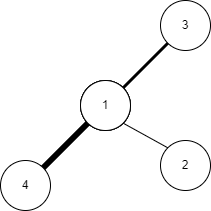

In the above graph, node 4 is more important than node 3, which is more important than node 2

In the following tutorial, we will see how to calculate these attention scores and implement an efficient GAT in PyTorch Geometric (PyG).

As an example, we consider the `CiteSeer` dataset, which is a citation network of scientific publications in the field of computer science. The dataset contains 3,312 publications and 4,732 citations between them. Each publication is described by a bag-of-words feature vector of size 3,703, representing the presence or absence of specific words in the publication's title, abstract, and keywords. The graph structure of the` Citeseer` dataset is based on the citation links between publications. Each node in the graph represents a publication, and each edge represents a citation from one publication to another. The dataset can be imported with the [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) class in PyTorch Geometric.


In [ ]:
import os
import torch
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import torch_geometric
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")

data = dataset[0] # Get the first graph object.

# Gather some statistics about the graph.
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Number of graphs: 1
Number of nodes: 3327
Average node degree: 2.74
Number of features: 3703
Number of classes: 6
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Graph Attention Layer 

Introduced by [Veličković et al.](https://arxiv.org/pdf/1710.10903.pdf) in 2017, self-attention in GATs relies on a simple idea: some nodes are more important than others. In this context, we talk about self-attention (and not just attention) because inputs are compared to each other.

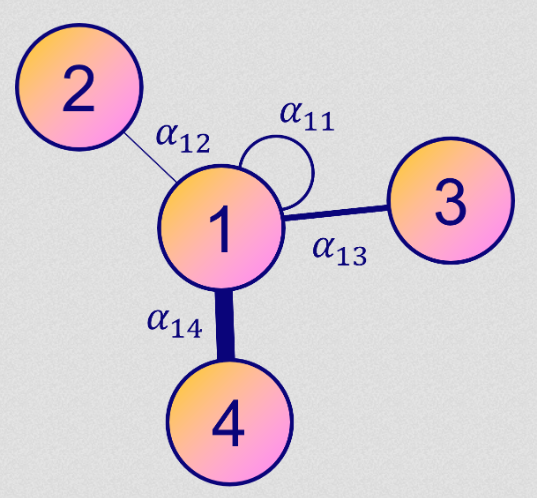

In the previous figure, self-attention calculates the importance of nodes 2, 3, and 4's features to node 1. We denote αᵢⱼ the importance of node j's features to node i.

Each node i has an attribute vector xᵢ. The GAT layer calculates the embedding of node 1 as a sum of attention coefficients multiplied by a shared weight matrix 𝐖 :

$$
h_i = \alpha_{11}\mathbf{W}x_1 + \alpha_{12}\mathbf{W}x_2 + \alpha_{13}\mathbf{W}x_3 + \alpha_{14}\mathbf{W}x_4
$$

But how do we calculate these attention coefficients? We could write a static formula, but there's a smarter solution: we can learn their values with a neural network. There are four steps in this process:

1. Linear transformation
2. Activation function
3. Softmax normalization
4. Multi-head attention

### Linear Transformation

To calculate the attention coefficient, we need to consider pairs of nodes. An easy way to create these pairs is to concatenate attribute vectors from both nodes.

Then, we can apply a new linear transformation with a weight matrix $W_{att}$

$$
a_{ij} = W_{att}^t [\mathbf{W}x_i || \mathbf{W}x_j] 
$$

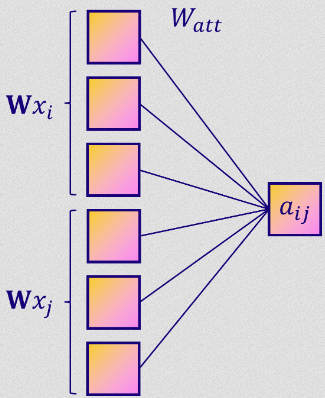

### Activation function

We're building a neural network, so the second step is to add nonlinearity with an activation function. In this case, the paper's authors chose the LeakyReLU `elu` function.

$$
e_{ij} = LeakyReLU(a_{ij})
$$

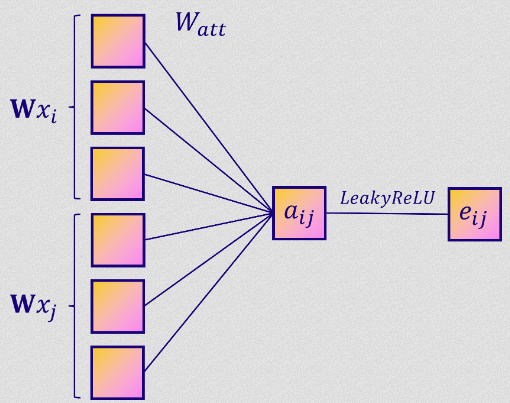

### Softmax normalization 

The output of our neural network is not normalized, which is a problem since we want to compare these coefficients. For example, to be able to say if node 2 is more important to node 1 than node 3 $(\alpha_{12} > \alpha_{13})$, we need to use the same scale. 

A common way to do it with neural networks is to use the softmax function. Here, we apply it to every neighboring node, including the target node itself:

$$
\alpha_{ij} = softmax_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in N_i} \exp({e_{ik})}}
$$

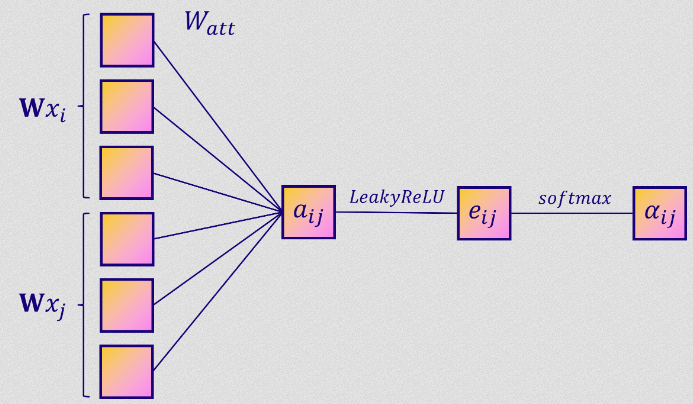

This equation produces the final attention coefficients $\alpha_{ij}$. The only problem is... self-attention is not very stable. In order to improve performance, Vaswani et al. introduced multi-head attention in the transformer architecture in their seminal [Attention is all you need](https://arxiv.org/abs/1706.03762) paper.


### Multi-head attention

This should not be a big surprise if you're familiar with the transformer architecture, but transformers are a special case of GNNs. This is why GATs look so much like a simplified version of transformers. The good thing is that we can reuse some ideas from Natural Language Processing here, like multi-head attention.

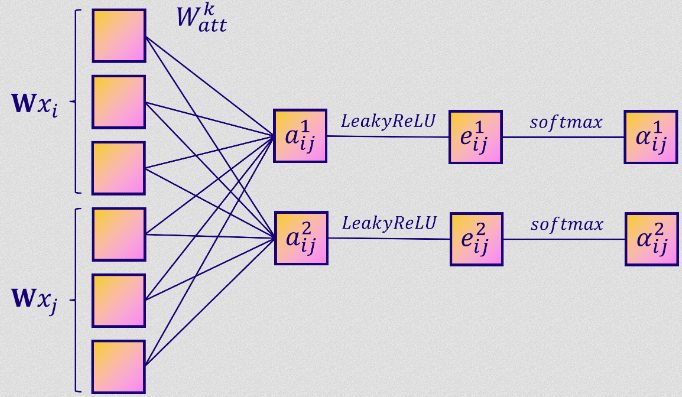

In GATs, multi-head attention consists of replicating the same three steps several times in order to average or concatenate the results. Instead of a single embedding $ℎ_1$, we get one embedding per attention head (denoted 
$ℎ_1^k$ for the head $k$. One of the two following schemes can then be applied:

Average: we sum the different $ℎ_i^k$ and normalize the result by the number of attention heads $n$;

$$
h_i = \frac{1}{n} \sum_{k=1}^n h_i^k
$$

Concatenation: we concatenate the different $h_i^k$.

$$
h_i = ||_{k=1}^n h_i^k
$$

In practice, we use the concatenation scheme when it's a hidden layer and the average scheme when it's the last (output) layer. Most of the time, we will stack several GAT layers to aggregate a larger neighborhood and thus combine these two schemes in the same GAT model.

## Implementing a GAT

Let's now implement a GAT using Pytorch Geometric. The library has a graph convolutional layer named `GATConv`, which is implemented as:
$$
GATConv: e_{ij} = LeakyReLU(W_{att}^t[\mathbf{W}x_i || \mathbf{W}x_j]) 
$$

Okay, not without further delay, let's classify the papers from CiteSeer. Here, we use graph attention layers in two configurations:

1. The first layer concatenates 8 outpurs (multi-head attention);
2. The second layer only has 1 head, which produces our final embeddings.

In [ ]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    torch.manual_seed(1234567)
    self.gat1 = GATConv(dim_in, dim_h, heads=heads)
    self.gat2 = GATConv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


In [ ]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

# Define the train function
def train(model, data):
    """Train the GAT model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 201
    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # Print metrics every 10 epochs
        if epoch in range (1, epochs):
          print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        

#Define the test function
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATConv(3703, 8, heads=8)
  (gat2): GATConv(64, 6, heads=1)
)


In [ ]:
# Train and print the model
train(gat, data)

Epoch: 001, Loss: 1.3647
Epoch: 002, Loss: 0.9813
Epoch: 003, Loss: 0.7126
Epoch: 004, Loss: 0.5096
Epoch: 005, Loss: 0.3495
Epoch: 006, Loss: 0.2479
Epoch: 007, Loss: 0.1948
Epoch: 008, Loss: 0.1469
Epoch: 009, Loss: 0.1100
Epoch: 010, Loss: 0.0847
Epoch: 011, Loss: 0.0687
Epoch: 012, Loss: 0.0666
Epoch: 013, Loss: 0.0385
Epoch: 014, Loss: 0.0360
Epoch: 015, Loss: 0.0278
Epoch: 016, Loss: 0.0272
Epoch: 017, Loss: 0.0273
Epoch: 018, Loss: 0.0219
Epoch: 019, Loss: 0.0207
Epoch: 020, Loss: 0.0175
Epoch: 021, Loss: 0.0167
Epoch: 022, Loss: 0.0303
Epoch: 023, Loss: 0.0089
Epoch: 024, Loss: 0.0077
Epoch: 025, Loss: 0.0076
Epoch: 026, Loss: 0.0098
Epoch: 027, Loss: 0.0049
Epoch: 028, Loss: 0.0034
Epoch: 029, Loss: 0.0035
Epoch: 030, Loss: 0.0267
Epoch: 031, Loss: 0.0047
Epoch: 032, Loss: 0.0030
Epoch: 033, Loss: 0.0058
Epoch: 034, Loss: 0.0027
Epoch: 035, Loss: 0.0036
Epoch: 036, Loss: 0.0036
Epoch: 037, Loss: 0.0041
Epoch: 038, Loss: 0.0036
Epoch: 039, Loss: 0.0104
Epoch: 040, Loss: 0.0027


In [ ]:
# Test
acc = test(gat, data)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.6870


Let's visualize the node embeddings of our untrained GAT network

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


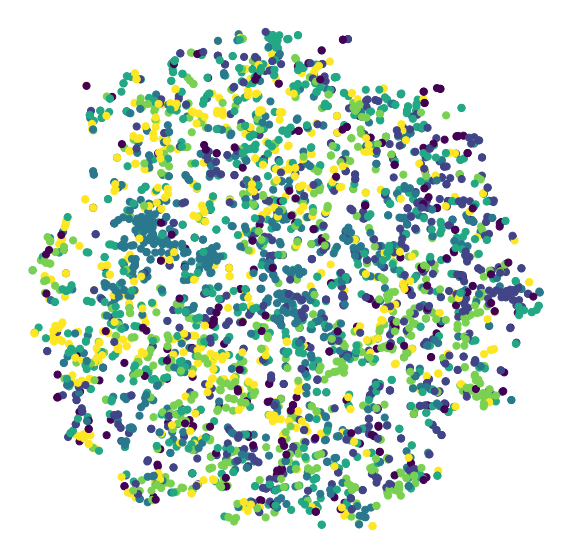

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

Now let's visualize the node embeddings after training. Doesn't it look better?

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


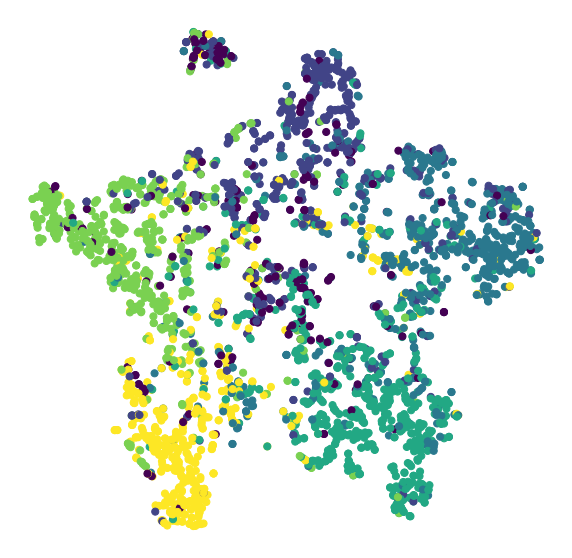

In [ ]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### Conclusion
In this tutorial, you have learned how Graph Attention Networks work and how they can be useful for various tasks.

### Acknowledgement
This tutorial was originally written by Maxime Labonne, Airbus SE. This version has been adapted and modified for the Spring 2023 edition of EEEM068 module at the University of Surrey.